In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])/np.sqrt(layer_dims[l-1])
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [3]:
def sigmoid(Z):
    
    cache = Z
    A = 1 / (1 + np.exp(-Z))
    
    return A, cache

def relu(Z):
    cache = Z
    A = np.maximum(0, Z)
    return A, cache

def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    return A, cache


def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters)//2
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation="relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    return AL, caches

In [4]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1 / m)*(np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1-Y, np.log(1-AL))))
    
    cost = np.squeeze(cost)
    return cost

In [5]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1 + np.exp(-Z))
    
    dZ = dA * s * (1 - s)
    
    return dZ

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy = True)
    
    dZ[Z <= 0] = 0
    
    return dZ

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dA_prev = np.dot(W.T, dZ)
    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*(np.sum(dZ, axis = 1, keepdims=True))
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    #print(cache.shape)
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = -(np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    
    for l in reversed(range(L-1)):
        dA_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], caches[l], "relu")
        grads["dA" + str(l)] = dA_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp
    return grads

In [6]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters)//2
    
    for l in range(L):
        
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
        
    return parameters

In [7]:
import scipy
from PIL import Image
from scipy import ndimage

In [8]:
def load_datasets():
    train_dataset = h5py.File('train_catvnoncat.h5', 'r')
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('test_catvnoncat.h5', 'r')
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(train_dataset["list_classes"][:])
    
    train_set_y_orig = train_set_y_orig.reshape(1, train_set_y_orig.shape[0])
    test_set_y_orig = test_set_y_orig.reshape(1, test_set_y_orig.shape[0])
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [9]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_datasets()

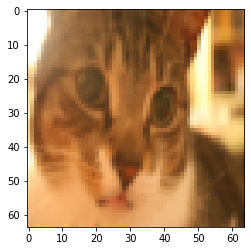

In [10]:
plt.imshow(train_set_x_orig[200])

In [11]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2]
print(m_train, m_test, num_px)

209 50 64


In [12]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

In [13]:
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255
train_set_x.shape

(12288, 209)

In [50]:
def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)
    b2 = np.zeros((n_y, 1))
    
    params = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    
    return params

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(A2, Y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

def predict(X, Y, parameters):
    predictions = np.zeros((1, X.shape[1]))
    A, cache = L_model_forward(X, parameters)
    for i in range(A.shape[1]):
        if(A[0, i] >= 0.5):
            print(A[0, i])
            predictions[0, i] = 1
        else:
            #print(A[0, i])
            predictions[0, i] = 0
    return predictions

In [15]:
n_x = 12288
n_h = 7
n_y = 1
layer_dims = (n_x, n_h, n_y)

Cost after iteration 0: 0.7278455788584787
Cost after iteration 100: 0.5431495211822982
Cost after iteration 200: 0.5061564999125854
Cost after iteration 300: 0.45742729943277266
Cost after iteration 400: 0.42283926723931675
Cost after iteration 500: 0.3968817978696322
Cost after iteration 600: 0.34167089414404567
Cost after iteration 700: 0.2984472792761445
Cost after iteration 800: 0.2862418005369951
Cost after iteration 900: 0.24436625132395143
Cost after iteration 1000: 0.20600424734841413
Cost after iteration 1100: 0.2012790954644062
Cost after iteration 1200: 0.15320429850263045
Cost after iteration 1300: 0.13143378058958002
Cost after iteration 1400: 0.10092404165677654
Cost after iteration 1500: 0.08839039594731257
Cost after iteration 1600: 0.07281680560035547
Cost after iteration 1700: 0.06609435553567695
Cost after iteration 1800: 0.06013760316040437
Cost after iteration 1900: 0.041675595754813104
Cost after iteration 2000: 0.03711081663320852
Cost after iteration 2100: 0.03

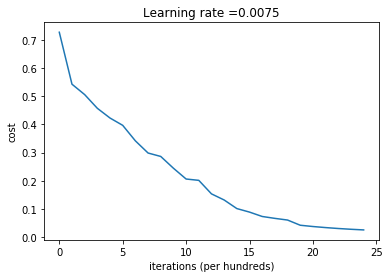

In [16]:
parameters = two_layer_model(train_set_x, train_set_y, layer_dims, num_iterations = 2500, print_cost=True)

In [17]:
predictions_train = predict(train_set_x, train_set_y, parameters)
predictions_test = predict(test_set_x, test_set_y, parameters)
print("Train accuracy is : {} %".format(100-np.mean(np.abs(predictions_train - train_set_y))*100))
print("Test accuracy is : {} %".format(100-np.mean(np.abs(predictions_test - test_set_y))*100))

Train accuracy is : 100.0 %
Test accuracy is : 70.0 %


In [18]:
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [19]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False):
    np.random.seed(1)
    costs = []
    print("Hello")
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
        
        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)

        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if i%100 == 0 and print_cost:
            print("Cost after %i th iteration is %f: "%(i, cost))
            costs.append(cost)
    print(len(caches))
    plt.plot(np.squeeze(costs))
    return parameters

Hello
Cost after 0 th iteration is 0.771749: 
Cost after 100 th iteration is 0.672053: 
Cost after 200 th iteration is 0.648263: 
Cost after 300 th iteration is 0.611507: 
Cost after 400 th iteration is 0.567047: 
Cost after 500 th iteration is 0.540138: 
Cost after 600 th iteration is 0.527930: 
Cost after 700 th iteration is 0.465477: 
Cost after 800 th iteration is 0.369126: 
Cost after 900 th iteration is 0.391747: 
Cost after 1000 th iteration is 0.315187: 
Cost after 1100 th iteration is 0.272700: 
Cost after 1200 th iteration is 0.237419: 
Cost after 1300 th iteration is 0.199601: 
Cost after 1400 th iteration is 0.189263: 
Cost after 1500 th iteration is 0.161189: 
Cost after 1600 th iteration is 0.148214: 
Cost after 1700 th iteration is 0.137775: 
Cost after 1800 th iteration is 0.129740: 
Cost after 1900 th iteration is 0.121225: 
Cost after 2000 th iteration is 0.113821: 
Cost after 2100 th iteration is 0.107839: 
Cost after 2200 th iteration is 0.102855: 
Cost after 2300 t

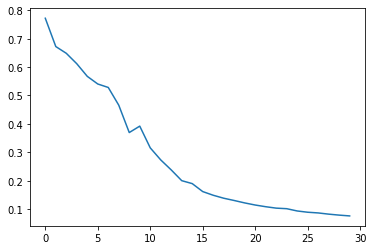

In [20]:
parameters = L_layer_model(train_set_x, train_set_y, layers_dims, num_iterations = 3000, print_cost = True)

In [21]:
predictions_train = predict(train_set_x, train_set_y, parameters)
predictions_test = predict(test_set_x, test_set_y, parameters)
print(predictions_train)
print("Train accuracy is : {} %".format(100-np.mean(np.abs(predictions_train - train_set_y))*100))
print("Test accuracy is : {} %".format(100-np.mean(np.abs(predictions_test - test_set_y))*100))

[[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
  0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.
  0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0.
  1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.
  0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Train accuracy is : 99.04306220095694 %
Test accuracy is : 82.0 %


0.9574159351151249
You're a cat


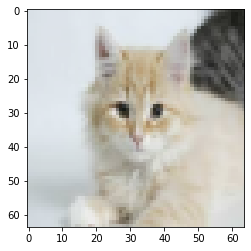

In [60]:
from skimage.transform import resize
import imageio
import scipy.misc
my_image = "cat.jpg"
my_label_y = [1]

fname = my_image
image = np.array(imageio.imread(fname))
my_image = resize(image, (64, 64, 3), anti_aliasing=True)
plt.imshow(my_image)
my_image = my_image.reshape(-1, 1)
predition_cat = predict(my_image, my_label_y, parameters)
if predition_cat == 1:
    print("You're a cat")
else:
    print("You're not a cat")